In [1]:
import os
import copy
import numpy as np
import pandas as pd
from PIL import Image
from scipy.optimize import minimize

In [2]:
fd = "/home/jupyter/ai_font/data/exp0717/train_whole/"
file = "교보손글씨2020박도연/교보손글씨2020박도연__우.png"

In [3]:
img = Image.open(fd+file)

In [4]:
def func_black(coefs):
    b0, b1 = coefs
    pred = b0 + b1*x_black
    return np.mean(np.abs(y_black-pred))

def func_white(coefs):
    b0, b1 = coefs
    pred = b0 + b1*x_white
    return np.mean(np.abs(y_white-pred))

In [5]:
def func_comb(coefs):
    b0, b1 = coefs
    pred_black = b0 + b1*x_black
    pred_white = b0 + b1*x_white
    return np.mean(np.abs(y_black-pred_black)) + np.mean(np.where(np.abs(y_white-pred_white)>2,0,np.abs(y_white-pred_white)))*2

In [6]:
def func_cond(coefs):
    b0, b1 = coefs
    pred_black = b0 + b1*x_black
    overlabpixels = np.where(y_black == pred_black.astype(np.int16), 1, 0)
    pen = len(overlabpixels) if np.any(overlabpixels) else 0
    return np.mean(np.abs(y_black-pred_black)) + np.sum(overlabpixels) + pen

In [7]:
x_black,y_black = np.where(np.array(img)!=255)
x_white,y_white = np.where(np.array(img)==255)

In [8]:
coef = np.array([0.,1.])
coefs = []
for _ in range(20):
    result = minimize(func_black, coef, method='Nelder-Mead')
    coefs.append(result.x)
    result = minimize(func_white, coef, method='Nelder-Mead')
    coefs.append(result.x)

In [9]:
coef = np.array([0.,1.])
result = minimize(func_comb, coef, method='Nelder-Mead')

In [10]:
coef = np.array([0.,1.])
result = minimize(func_cond, coef, method='Nelder-Mead')

In [11]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 668.028064250052
             x: [ 3.676e-04  1.074e+00]
           nit: 24
          nfev: 54
 final_simplex: (array([[ 3.676e-04,  1.074e+00],
                       [ 3.613e-04,  1.074e+00],
                       [ 3.618e-04,  1.074e+00]]), array([ 6.680e+02,  6.680e+02,  6.680e+02]))

In [12]:
np.mean(np.stack(coefs),axis=0)

array([6.54999063e+01, 1.20745507e-06])

In [13]:
def dividing(coefs):
    b0, b1 = coefs
    pred = b0 + b1*x_black
    return np.where(pred > y_black, 0, 1)

In [14]:
maps = dividing(result.x)

In [15]:
npimg = np.array(img)
for i,j,k in zip(x_black,y_black,maps):
    if k == 0:
        npimg[i,j] = 255
        
npimg[40,64] = 0
npimg[41,64] = 0
npimg[42,64] = 0

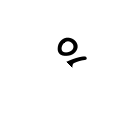

In [16]:
Image.fromarray(npimg)

In [17]:
import numpy as np
from scipy.spatial.distance import cdist

# Example data
point1 = np.array([[1, 2]])
point2 = np.array([[3, 4]])
points = np.array([[0, 1], [1, 0], [2, 2], [3, 3], [4, 4]])

# Combine the two points into a single array
reference_points = np.vstack([point1, point2])

# Compute pairwise distances
pairwise_distances = cdist(reference_points, points, metric='euclidean')

print("Pairwise distances between reference points and other points:")
print(pairwise_distances)


Pairwise distances between reference points and other points:
[[1.41421356 2.         1.         2.23606798 3.60555128]
 [4.24264069 4.47213595 2.23606798 1.         1.        ]]


In [18]:
import numpy as np
from scipy.spatial.distance import cdist

# Example data
point1 = np.array([[0, 64]])
point2 = np.array([[128, 64]])
points = np.stack([x_black,y_black],1)

# Combine the two points into a single array
reference_points = np.vstack([point1, point2])

# Compute pairwise distances
pairwise_distances = cdist(reference_points, points, metric='euclidean')

print("Pairwise distances between reference points and other points:")
print(pairwise_distances)


Pairwise distances between reference points and other points:
[[37.01351105 37.05401463 37.12142239 ... 90.08884504 90.13878189
  90.19977827]
 [91.00549434 91.02197537 91.04943712 ... 38.20994635 38.32753579
  38.47076812]]


In [19]:
np.sum(pairwise_distances,0).shape

(646,)

In [20]:
ratios = pairwise_distances[0]/np.sum(pairwise_distances,0)

(array([29., 44., 31., 29., 32., 39., 41., 20., 46., 42., 51., 52., 70.,
        32., 12., 18., 17., 13., 17., 11.]),
 array([0.28912513, 0.30977787, 0.33043061, 0.35108336, 0.3717361 ,
        0.39238884, 0.41304159, 0.43369433, 0.45434707, 0.47499982,
        0.49565256, 0.51630531, 0.53695805, 0.55761079, 0.57826354,
        0.59891628, 0.61956902, 0.64022177, 0.66087451, 0.68152725,
        0.70218   ]),
 <BarContainer object of 20 artists>)

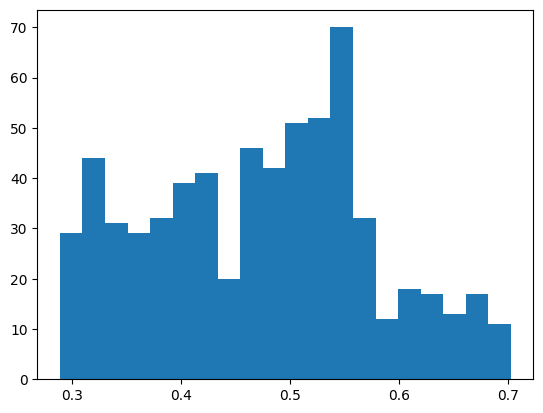

In [21]:
import matplotlib.pyplot as plt
plt.hist(ratios,bins=20)

In [22]:
np.stack([x_black,y_black],1).shape

(646, 2)

In [23]:
endpoint = np.array([[128, 64]])
points = np.stack([x_black,y_black],1)
dist = cdist(endpoint, points, metric='euclidean')

In [24]:
anchor = points[np.argsort(dist.reshape(-1))][:8]
leftpoints = points[np.argsort(dist.reshape(-1))][8:]

In [25]:
noerror = True
len_near = 1
while (len(leftpoints) > 0) & noerror & (len_near>0):
    try:
        dist = cdist(anchor, leftpoints, metric='euclidean')
        wherenear = np.where(np.min(dist,0) < 1.5)[0]
        len_near = len(wherenear)
        anchor = np.concatenate([anchor, leftpoints[wherenear,:]])
        leftpoints = np.delete(leftpoints, wherenear,axis=0)
    except:
        noerror = False
    print(len_near)

6
6
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
9
13
16
19
18
17
17
15
14
12
11
11
10
10
10
5
5
5
6
6
6
5
5
5
5
3
0


In [31]:
anchor

array([[90, 68],
       [90, 69],
       [90, 70],
       [89, 68],
       [89, 69],
       [89, 70],
       [89, 71],
       [88, 68],
       [88, 69],
       [88, 70],
       [88, 71],
       [87, 67],
       [87, 68],
       [87, 69],
       [87, 70],
       [87, 71],
       [86, 67],
       [86, 68],
       [86, 69],
       [86, 70],
       [86, 71],
       [86, 72],
       [85, 67],
       [85, 68],
       [85, 69],
       [85, 70],
       [85, 71],
       [85, 72],
       [84, 67],
       [84, 68],
       [84, 69],
       [84, 70],
       [84, 71],
       [84, 72],
       [83, 67],
       [83, 68],
       [83, 69],
       [83, 70],
       [83, 71],
       [83, 72],
       [82, 67],
       [82, 68],
       [82, 69],
       [82, 70],
       [82, 71],
       [82, 72],
       [81, 67],
       [81, 68],
       [81, 69],
       [81, 70],
       [81, 71],
       [81, 72],
       [80, 67],
       [80, 68],
       [80, 69],
       [80, 70],
       [80, 71],
       [80, 72],
       [79, 67

In [32]:
leftpoints.shape

(245, 2)

In [28]:
wherenear

array([], dtype=int64)

In [29]:
wherenear

array([], dtype=int64)

In [37]:
np.array(img)[np.where(np.array(img)!=255)]

array([239, 186, 177, 182, 219, 254, 180,  61,   2,   0,   0,   0,   0,
        19, 105, 215, 237,  79,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   4, 111, 249, 231,  37,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  56, 241, 246,  45,   0,   0,   0,   0,
        11, 101, 161, 160, 101,  10,   0,   0,   0,   0,  63, 252, 111,
         0,   0,   0,   0,  78, 234, 231,  68,   0,   0,   0,   0, 136,
       218,   2,   0,   0,   0,  96, 254, 250,  70,   0,   0,   0,  17,
       245, 107,   0,   0,   0,  44, 250, 233,  10,   0,   0,   0, 168,
        30,   0,   0,   0, 180,  73,   0,   0,   0, 114, 228,   0,   0,
         0,  26, 254, 111,   0,   0,   0, 102, 195,   0,   0,   0,  87,
        93,   0,   0,   0, 113, 178,   0,   0,   0, 107, 247,  22,   0,
         0,   0, 174, 181,   0,   0,   0,  78, 119,   0,   0,   0,  18,
       243, 212,   0,   0,   0,  12, 237, 251, 124,   0,   0,   0,   0,
       138, 254,  27,   0,   0,   0,  63, 230, 246, 164,  43,   